<a href="https://colab.research.google.com/github/esterfb3397/fake-news-project-tfm/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias


In [1]:
#!pip install contractions

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string 
import re 
import contractions 
#import warnings
#warnings.filterwarnings('error')
from tqdm.autonotebook import tqdm
tqdm.pandas()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report

<ipython-input-2-0d0a23bb6cb9>:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [1]:
!git clone https://github.com/esterfb3397/fake-news-project-tfm.git

Cloning into 'fake-news-project-tfm'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 14 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (14/14), done.


# Unificación dataset

Este dataset viene de la página https://www.uvic.ca/ecs/ece/isot/datasets/fake-news/index.php. 
Está dividido en dos conjuntos de datos: real y fake. Los datos de real se recopilaron a partir de fuentes del mundo real a partir de noticias seleccionadas de  la página Reuter. En cambio, las fake news  procedían de sitios web poco fiables marcados por Politifact (una organización de comprobación de hechos de EE.UU.) y Wikipedia.
de EE.UU.) y Wikipedia. El conjunto de datos contiene distintos tipos de artículos sobre diferentes temas.
Sin embargo, la mayoría de los artículos se centran en noticias políticas y mundiales. 



Nos traemos de local los dos dataset


In [4]:
fake = pd.read_csv('/content/fake-news-project-tfm/data/Fake.csv',delimiter=',',encoding='utf8', engine='python')
real = pd.read_csv('/content/fake-news-project-tfm/data/True.csv',delimiter=',',encoding='utf8', engine='python')

Vemos que se han importado correctamente

In [5]:
fake.head(2)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"


In [6]:
real.head(2)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"


Tenemos que juntar el dataframe por lo que primero habrá que crear una nueva columna para ver si es fake news o no. En caso afirmativo la columna tendrá valor de 1 (fake news) y para las real news tendrá un valor de 0.

In [7]:
fake.insert(4, 'label', '1')

In [8]:
fake.head(2)

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1


In [9]:
#real.to_excel('/content/fake-news-project-tfm/pruebas/real.xlsx')

In [10]:
real.insert(4, 'label', '0')

In [11]:
real.head(2)

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0


Ahora juntamos unimos fake y real en un solo dataframe.

In [12]:
df = pd.concat([real,fake])


In [13]:
df.head(2)

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0


In [14]:
df.tail(2)

,title,text,subject,date,label
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",1
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",1


In [15]:
#Primero comprobamos el tamaño y las columnas
print(len(df))
print(df.shape[1])

44898
5


Despues, comprobamos y eliminamos las filas con algún valor vacío (NA) y quitaremos los duplicados

In [16]:
np.sum(df.duplicated())

209

Como han salido filas duplicadas, las tenemos que limpiar

In [17]:
df.drop_duplicates(inplace=True)

In [18]:
np.sum(df.duplicated())

0

Como ya se han tratado las filas con duplicados vamos a ver si existen NAN y eliminarlos.

In [19]:
print(np.sum(df.isnull()))

title      0
text       0
subject    0
date       0
label      0
dtype: int64


Ahora vamos a comprobar si el dataset es balanceado o no

In [20]:
df['label'].value_counts()

1    23478
0    21211
Name: label, dtype: int64

A primer vistazo podemos observar que está bastante balanceado

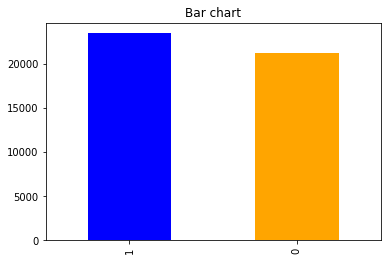

In [21]:
ax, fig = plt.subplots()
etiquetas = df['label'].value_counts()
etiquetas.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

Podemos concluir que el dataset está balanceado aunque las fake news ganan a las real news

Antes de proceder al preprocesado del dataset, vamos a añadir una columna llamada length para ir determinando y comparando el numero de caracteres de cada columna.

In [22]:
df['length'] = df['text'].apply(lambda x: len(x))

In [23]:
df.head(2)

,title,text,subject,date,label,length
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0,4659
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0,4077


En clase, se ha realizado el código de a continuación para poder visualizar mejor la distribucion de la longitud de las noticias en caracteres

In [26]:
df.shape

(44689, 6)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44689 entries, 0 to 23480
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44689 non-null  object
 1   text     44689 non-null  object
 2   subject  44689 non-null  object
 3   date     44689 non-null  object
 4   label    44689 non-null  object
 5   length   44689 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 2.4+ MB


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


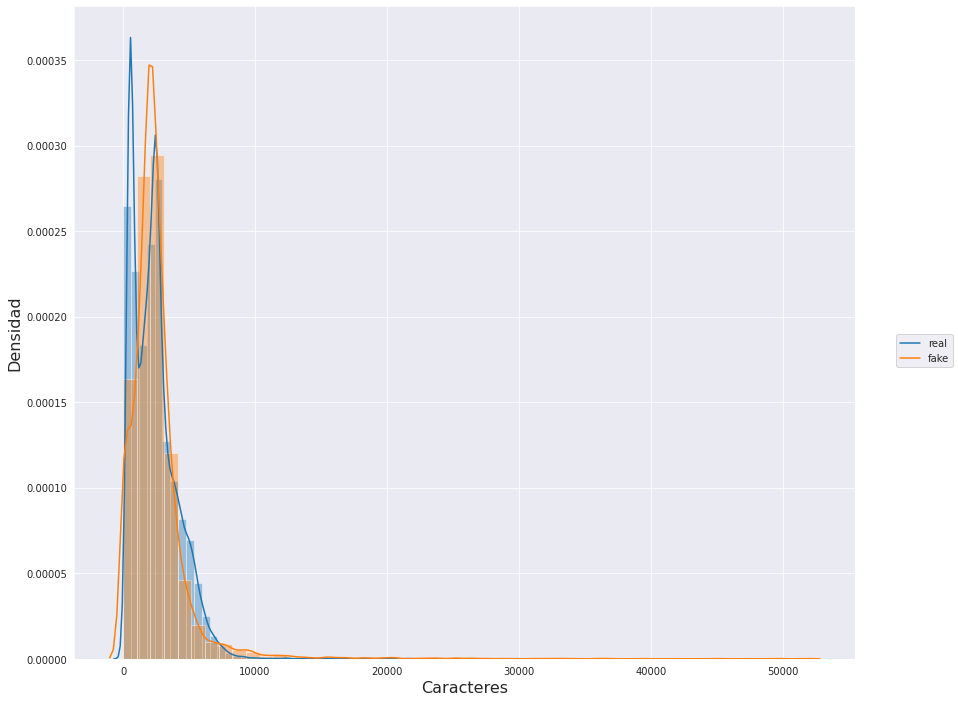

In [33]:
fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")
# añadimos series para cada categoría (eligiendo la seríe de char_len
plt1 = sns.distplot(df[df.label=='0'].length, hist=True, label="real")
plt2 = sns.distplot(df[df.label=='1'].length, hist=True, label="fake")
fig.legend(labels=['real','fake'], loc = 5)


# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()

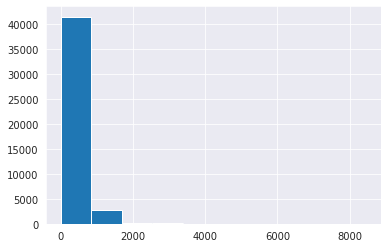

In [40]:
# Calcular número de palabras por documento
df["nwords"] = df["text"].apply(lambda s: len(s.split(" ")))
df["nwords"].hist()

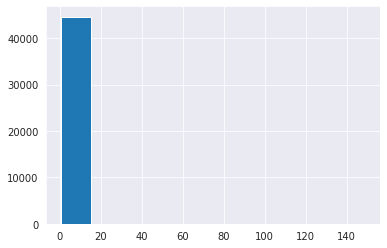

In [43]:
# Calcular media de caracteres por palabra
df["avg_char_word"] = df["text"].apply(lambda s: len(s) / len(s.split(" ")))
df["avg_char_word"].hist()

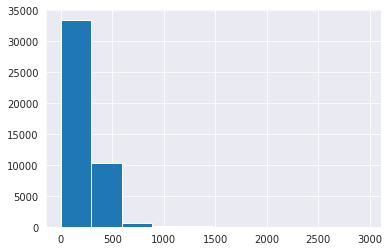

In [42]:
# Calcular número de palabras distintas
df["n_distint_word"] = df["text"].apply(lambda s: len(set(s.split(" "))))
df["n_distint_word"].hist()

In [50]:
df["nwords"].describe(percentiles=[0.05])

count    44689.000000
mean       415.434335
std        361.968943
min          1.000000
5%          52.000000
50%        370.000000
max       8436.000000
Name: nwords, dtype: float64

In [54]:
df[df["nwords"] < 25]["text"].tolist()[1]

'MOSCOW (Reuters) - Russian President Vladimir Putin said on Friday he wanted constructive relations with the United States under President-elect Donald Trump. '